In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/chieh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# DATASET
DATASET_COLUMNS = ["TWID","TEXT","VALUE"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [4]:
dataset_filename = os.listdir("./data")[1]
dataset_path = os.path.join("./","data",dataset_filename)
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING ,
                 lineterminator='\n')

Open file: ./data/twitt_sample.csv


In [5]:
print("Dataset size:", len(df))

Dataset size: 258322


In [6]:
df.head(10)

,TWID,TEXT,VALUE
0,1.467811e+09,@Kenichan I dived many times for the ball. Man...,-1
1,1.467811e+09,"@nationwideclass no, it's not behaving at all....",-1
2,1.467814e+09,"one of my friend called me, and asked to meet ...",-1
3,1.467817e+09,@MissXu sorry! bed time came here (GMT+1) ht...,-1
4,1.467822e+09,"@andywana Not sure what they are, only that th...",-1
5,1.467825e+09,@katortiz Not forever... See you soon!,-1
6,1.467826e+09,Why won't you show my location?! http://twit...,-1
7,1.467834e+09,i think my arms are sore from tennis,-1
8,1.467841e+09,@allyheman but.. but.. but.. I'm not a big fan...,-1
9,1.467843e+09,@ozesteph1992 Shame to hear this Stephan,-1


In [7]:
decode_map = {-1: "NEGATIVE", 0: "NEUTRAL", 1: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df.VALUE = df.VALUE.apply(lambda x: decode_sentiment(x))

CPU times: user 89.5 ms, sys: 4.6 ms, total: 94.1 ms
Wall time: 100 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

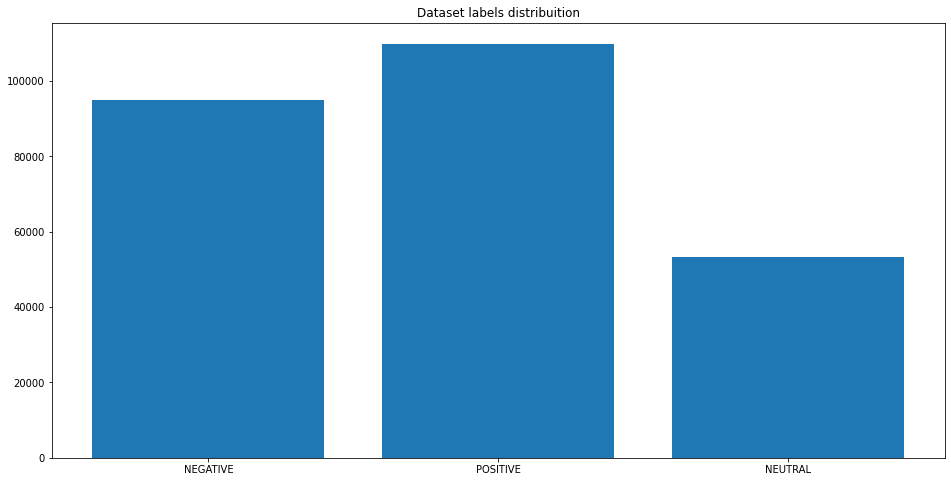

In [9]:
target_cnt = Counter(df.VALUE)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [10]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [11]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [12]:
%%time
df.TEXT = df.TEXT.apply(lambda x: preprocess(x))

CPU times: user 7.97 s, sys: 91 ms, total: 8.07 s
Wall time: 8.34 s


In [13]:
df.TEXT.head(10)

0    dived many times ball managed save 50 rest go ...
1                                     behaving mad see
2    one friend called asked meet mid valley today ...
3                            sorry bed time came gmt 1
4    sure pos much want dont think trade away compa...
5                                     forever see soon
6                                        show location
7                               think arms sore tennis
8                                big fan camilla belle
9                                   shame hear stephan
Name: TEXT, dtype: object

In [14]:
# split train, test data 
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 206657
TEST size: 51665


In [20]:
df_train.head()

,TWID,TEXT,VALUE
82347,1.553709e+09,writing,POSITIVE
127981,2.000995e+09,tons followers follow,POSITIVE
237873,8.006250e+17,happy monday hope smashing week happymonday mo...,POSITIVE
821,1.470041e+09,made ontd entry also happens flocked,NEGATIVE
100674,1.880255e+09,glad developed test suite amberdms billing sys...,POSITIVE


In [29]:
# word 2 vec
documents = [_text.split() for _text in df_train.TEXT]

In [31]:
print(documents[0])

['writing']


In [32]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [33]:
w2v_model.build_vocab(documents)

2020-11-19 12:28:24,159 : INFO : collecting all words and their counts
2020-11-19 12:28:24,161 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-11-19 12:28:24,203 : INFO : PROGRESS: at sentence #10000, processed 72495 words, keeping 17777 word types
2020-11-19 12:28:24,237 : INFO : PROGRESS: at sentence #20000, processed 145452 words, keeping 27973 word types
2020-11-19 12:28:24,265 : INFO : PROGRESS: at sentence #30000, processed 218901 words, keeping 36356 word types
2020-11-19 12:28:24,289 : INFO : PROGRESS: at sentence #40000, processed 291426 words, keeping 43945 word types
2020-11-19 12:28:24,311 : INFO : PROGRESS: at sentence #50000, processed 364256 words, keeping 50892 word types
2020-11-19 12:28:24,337 : INFO : PROGRESS: at sentence #60000, processed 436645 words, keeping 57170 word types
2020-11-19 12:28:24,363 : INFO : PROGRESS: at sentence #70000, processed 509358 words, keeping 62997 word types
2020-11-19 12:28:24,385 : INFO : PROGRESS: at s

In [34]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 12531


In [35]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-11-19 12:28:53,249 : INFO : training model with 8 workers on 12531 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-11-19 12:28:54,314 : INFO : EPOCH 1 - PROGRESS: at 68.00% examples, 842204 words/s, in_qsize 16, out_qsize 0
2020-11-19 12:28:54,653 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-11-19 12:28:54,689 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-11-19 12:28:54,691 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-11-19 12:28:54,692 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-11-19 12:28:54,692 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-19 12:28:54,704 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-19 12:28:54,737 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-19 12:28:54,743 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-

2020-11-19 12:29:06,918 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-11-19 12:29:06,927 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-11-19 12:29:06,928 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-19 12:29:06,939 : INFO : EPOCH 9 - PROGRESS: at 98.68% examples, 605578 words/s, in_qsize 2, out_qsize 1
2020-11-19 12:29:06,939 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-19 12:29:06,944 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-19 12:29:06,953 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-19 12:29:06,954 : INFO : EPOCH - 9 : training on 1499974 raw words (1239768 effective words) took 2.0s, 609056 effective words/s
2020-11-19 12:29:07,968 : INFO : EPOCH 10 - PROGRESS: at 57.96% examples, 716393 words/s, in_qsize 14, out_qsize 1
2020-11-19 12:29:08,526 : INFO : worker thread finished; awaiting finish of 7 more thread

2020-11-19 12:29:19,491 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-19 12:29:19,492 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-19 12:29:19,505 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-19 12:29:19,506 : INFO : EPOCH - 17 : training on 1499974 raw words (1240154 effective words) took 1.7s, 729538 effective words/s
2020-11-19 12:29:20,551 : INFO : EPOCH 18 - PROGRESS: at 66.67% examples, 799406 words/s, in_qsize 15, out_qsize 0
2020-11-19 12:29:20,993 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-11-19 12:29:20,997 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-11-19 12:29:21,023 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-11-19 12:29:21,027 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-11-19 12:29:21,036 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-19 12:29:21

2020-11-19 12:29:33,042 : INFO : EPOCH 26 - PROGRESS: at 68.68% examples, 849768 words/s, in_qsize 16, out_qsize 1
2020-11-19 12:29:33,376 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-11-19 12:29:33,394 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-11-19 12:29:33,400 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-11-19 12:29:33,409 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-11-19 12:29:33,417 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-11-19 12:29:33,426 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-11-19 12:29:33,433 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-11-19 12:29:33,433 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-11-19 12:29:33,434 : INFO : EPOCH - 26 : training on 1499974 raw words (1239953 effective words) took 1.4s, 889296 effective words/s
2020-11-19 12:29:34

CPU times: user 2min 23s, sys: 1.34 s, total: 2min 25s
Wall time: 49 s


(39679676, 47999168)

In [36]:
w2v_model.most_similar("love")

/Users/chieh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-11-19 12:30:58,668 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.4769320785999298),
 ('loved', 0.43217742443084717),
 ('loves', 0.41431283950805664),
 ('lovee', 0.36954134702682495),
 ('thankful', 0.3435690999031067),
 ('demi', 0.34211021661758423),
 ('mileycyrus', 0.33798059821128845),
 ('ily', 0.33211320638656616),
 ('adore', 0.32305991649627686),
 ('loooove', 0.3196525573730469)]

In [38]:
# Tokenize Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.TEXT)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 127527


In [39]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.TEXT), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.TEXT), maxlen=SEQUENCE_LENGTH)

In [41]:
# Label encoder
labels = df_train.VALUE.unique().tolist()
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [42]:
encoder = LabelEncoder()
encoder.fit(df_train.VALUE.tolist())

y_train = encoder.transform(df_train.VALUE.tolist())
y_test = encoder.transform(df_test.VALUE.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (206657, 1)
y_test (51665, 1)


In [43]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (206657, 300)
y_train (206657, 1)
x_test (51665, 300)
y_test (51665, 1)


In [45]:
# Embedding Layer
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(127527, 300)


In [46]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [47]:
#Build Model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          38258100  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 38,418,601
Trainable params: 160,501
Non-trainable params: 38,258,100
_________________________________________________________________


In [48]:
# Compile model
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [49]:
# Callbacks
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [51]:
# Train
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
182/182 [==============================] - ETA: 0s - loss: -3.1005 - accuracy: 0.2818WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-11-19 13:03:57,848 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


182/182 [==============================] - 1345s 7s/step - loss: -3.1005 - accuracy: 0.2818 - val_loss: -6.3541 - val_accuracy: 0.3282
Epoch 2/8
182/182 [==============================] - ETA: 0s - loss: -8.6341 - accuracy: 0.3325WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-11-19 13:26:48,150 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


182/182 [==============================] - 1363s 7s/step - loss: -8.6341 - accuracy: 0.3325 - val_loss: -12.1032 - val_accuracy: 0.3398
Epoch 3/8
 95/182 [==============>...............] - ETA: 10:27 - loss: -12.3368 - accuracy: 0.3303

KeyboardInterrupt: 

In [52]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

21/21 [==============================] - 24s 1s/step - loss: -14.6257 - accuracy: 0.3346

ACCURACY: 0.3346075713634491
LOSS: -14.625689506530762


In [53]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

NameError: name 'history' is not defined

In [54]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [55]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [56]:
predict("I love the music")

{'label': 'POSITIVE', 'score': 1.0, 'elapsed_time': 0.38455700874328613}

In [57]:
predict("i don't know what i'm doing")

{'label': 'POSITIVE', 'score': 1.0, 'elapsed_time': 0.09198284149169922}

In [58]:
predict("I hate the rain")

{'label': 'NEUTRAL',
 'score': 0.4151146709918976,
 'elapsed_time': 0.0899190902709961}

In [59]:
predict("Bad guys")

{'label': 'NEGATIVE',
 'score': 0.1445106565952301,
 'elapsed_time': 0.09254717826843262}

In [62]:
predict("fuck u all")

{'label': 'POSITIVE',
 'score': 0.9558982253074646,
 'elapsed_time': 0.07656407356262207}

In [64]:
#Save model
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-11-19 13:45:07,272 : INFO : saving Word2Vec object under model.w2v, separately None
2020-11-19 13:45:07,274 : INFO : not storing attribute vectors_norm
2020-11-19 13:45:07,275 : INFO : not storing attribute cum_table
2020-11-19 13:45:07,705 : INFO : saved model.w2v
